# MY NLP MODELING EXERCISES

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import re
import env
import acquire
import prepare
from wordcloud import WordCloud
import nltk.sentiment
pd.set_option('display.max_colwidth', None)
from time import strftime
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
#acquire data from spam_db

from env import user, password, host
raw = pd.read_csv("spam_clean - spam_clean.csv")

raw.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


In [3]:
raw['cleaned']=raw.text.apply(prepare.basic_clean).apply(prepare.tokenize)\
.apply(prepare.remove_stopwords, extra_words=[], 
                                   exclude_words=[])
raw['stemmed'] = raw.cleaned.apply(prepare.stem)
raw['lemmatized']= raw.cleaned.apply(prepare.lemmatize)
raw = raw.drop(columns=['text','cleaned','stemmed'])
raw.head()

,label,lemmatized
0,ham,go jurong point crazy available bugis n great world la e buffet cine got amore wat
1,ham,ok lar joking wif u oni
2,spam,free entry 2 wkly comp win fa cup final tkts 21st may 2005 text fa 87121 receive entry questionstd txt ratetcs apply 08452810075over18s
3,ham,u dun say early hor u c already say
4,ham,nah dont think go usf life around though


In [4]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   label       5572 non-null   object
 1   lemmatized  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [5]:
raw.shape

(5572, 2)

<AxesSubplot:xlabel='label', ylabel='count'>

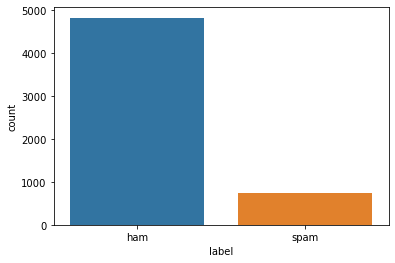

In [6]:
sns.countplot(data=raw,x='label')

# I'm really interested in applying SMOTE to the spam data to equal out the number of observations for either category

In [12]:
raw.label.mode()

0    ham
dtype: object

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score


df = raw
df.head()

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.lemmatized)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [19]:
train

,actual,predicted
1087,ham,ham
1167,ham,ham
2220,ham,ham
3454,ham,ham
2621,ham,ham
...,...,...
5263,ham,ham
273,ham,ham
4259,ham,ham
2024,ham,ham


In [10]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 96.66%
---
Confusion Matrix
actual      ham  spam
predicted            
ham        3854   144
spam          5   454
---
              precision    recall  f1-score   support

         ham       0.96      1.00      0.98      3859
        spam       0.99      0.76      0.86       598

    accuracy                           0.97      4457
   macro avg       0.98      0.88      0.92      4457
weighted avg       0.97      0.97      0.96      4457



In [11]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))


Accuracy: 94.44%
---
Confusion Matrix
actual     ham  spam
predicted           
ham        960    56
spam         6    93
---
              precision    recall  f1-score   support

         ham       0.94      0.99      0.97       966
        spam       0.94      0.62      0.75       149

    accuracy                           0.94      1115
   macro avg       0.94      0.81      0.86      1115
weighted avg       0.94      0.94      0.94      1115



# Up to here, this notebook follows the lesson

# From here, attempting to apply a Random Forest model

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [13]:
# This will be our baseline value for our Random Forest model

y_train.mode()

0    ham
dtype: object

In [15]:
# Produce a boolean array with True representing a match between the baseline prediction and reality
matches_baseline_prediction = y_train == 'ham'

baseline_accuracy = matches_baseline_prediction.mean()
print(f"Baseline accuracy: {round(baseline_accuracy, 2)}")

Baseline accuracy: 0.87


In [17]:
# Make the model
forest1 = RandomForestClassifier(max_depth=1, random_state=123)

# Fit the model (on train and only train)
forest1.fit(X_train, y_train)

# Use the model
# We'll evaluate the model's performance on train, first
y_predictions = forest1.predict(X_train)

# Produce the classification report on the actual y values and this model's predicted y values
report = classification_report(y_train, y_predictions, output_dict=True)
print("Tree of 1 depth")
pd.DataFrame(report)

Tree of 1 depth


/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,ham,spam,accuracy,macro avg,weighted avg
precision,0.865829,0.0,0.865829,0.432915,0.749660
recall,1.000000,0.0,0.865829,0.500000,0.865829
f1-score,0.928090,0.0,0.865829,0.464045,0.803568
support,3859.000000,598.0,0.865829,4457.000000,4457.000000


In [29]:
train_rf = pd.DataFrame(dict(actual=y_train))
test_rf = pd.DataFrame(dict(actual=y_test))

train_rf['predicted_rf'] = forest1.predict(X_train)
test_rf['predicted_rf'] = forest1.predict(X_test)

In [30]:
print('Accuracy: {:.2%}'.format(accuracy_score(train_rf.actual, train_rf.predicted_rf)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train_rf.predicted_rf, train_rf.actual))
print('---')
print(classification_report(train_rf.actual, train_rf.predicted_rf))

Accuracy: 86.58%
---
Confusion Matrix
actual         ham  spam
predicted_rf            
ham           3859   598
---
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93      3859
        spam       0.00      0.00      0.00       598

    accuracy                           0.87      4457
   macro avg       0.43      0.50      0.46      4457
weighted avg       0.75      0.87      0.80      4457



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [21]:
# sklearn confusion matrix
pd.DataFrame(confusion_matrix(y_predictions, y_train))

,0,1
0,3859,598
1,0,0


In [31]:
# Let's 
for i in range(2, 11):
    # Make the model
    forest = RandomForestClassifier(max_depth=i, random_state=123)

    # Fit the model (on train and only train)
    forest = forest.fit(X_train, y_train)

    # Use the model
    # We'll evaluate the model's performance on train, first
    y_predictions = forest.predict(X_train)

    # Produce the classification report on the actual y values and this model's predicted y values
    report = classification_report(y_train, y_predictions, output_dict=True)
    print(f"Tree with max depth of {i}")
    print(pd.DataFrame(report))
    print()

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tree with max depth of 2
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tree with max depth of 3
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tree with max depth of 4
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000



/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Tree with max depth of 5
                   ham   spam  accuracy    macro avg  weighted avg
precision     0.865829    0.0  0.865829     0.432915      0.749660
recall        1.000000    0.0  0.865829     0.500000      0.865829
f1-score      0.928090    0.0  0.865829     0.464045      0.803568
support    3859.000000  598.0  0.865829  4457.000000   4457.000000

Tree with max depth of 6
                   ham        spam  accuracy    macro avg  weighted avg
precision     0.867581    1.000000  0.867848     0.933790      0.885348
recall        1.000000    0.015050  0.867848     0.507525      0.867848
f1-score      0.929096    0.029654  0.867848     0.479375      0.808417
support    3859.000000  598.000000  0.867848  4457.000000   4457.000000

Tree with max depth of 7
                   ham        spam  accuracy    macro avg  weighted avg
precision     0.872090    1.000000  0.873009     0.936045      0.889252
recall        1.000000    0.053512  0.873009     0.526756      0.873009
f1-score    

# Linear Regression is beating the Random Forest for accuracy on every max depth